# Gradient Visualization for Radial 1D Stellar Wind Simulation

## Imports

In [2]:
# numerics
import jax
import jax.numpy as jnp
import numpy as np
import optax

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt

# fluids
from jf1uids.boundaries import OPEN_BOUNDARY, REFLECTIVE_BOUNDARY
from jf1uids.geometry import SPHERICAL
from jf1uids.physics_modules.stellar_wind import WindParams
from jf1uids.postprocessing import shock_sensor, strongest_shock_radius
from jf1uids.simulation_config import SimulationConfig
from jf1uids.simulation_helper_data import get_helper_data
from jf1uids.simulation_params import SimulationParams
from jf1uids.time_integration import time_integration
from jf1uids.fluid import primitive_state

# units
from jf1uids.unit_helpers import CodeUnits
from astropy import units as u
import astropy.constants as c
from astropy.constants import m_p

# wind-specific
from weaver import Weaver
from jax import grad

# # 64-bit precision
jax.config.update("jax_enable_x64", True)

## Initiating the stellar wind simulation

In [3]:
from jf1uids.geometry import CARTESIAN


print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
alpha = SPHERICAL
box_size = 1.0
num_cells = 100
dx = box_size / num_cells

fixed_timestep = False

checkpointing = True
num_checkpoints = 40

# introduce constants to 
# make this more readable
left_boundary = REFLECTIVE_BOUNDARY
right_boundary = OPEN_BOUNDARY

# activate stellar wind
stellar_wind = False

# setup simulation config
config = SimulationConfig(
    alpha_geom = alpha,
    box_size = box_size, 
    num_cells = num_cells,
    left_boundary = left_boundary, 
    right_boundary = right_boundary, 
    stellar_wind = stellar_wind,
    fixed_timestep = fixed_timestep,
    checkpointing = checkpointing,
    num_checkpoints = num_checkpoints
)

helper_data = get_helper_data(config)

👷 Setting up simulation...


2024-09-07 15:14:05.044149: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Setting the simulation parameters and initial state

In [4]:

# time domain
dt_max = 0.1
C_CFL = 0.6
t_end = 0.15

# SOD shock tube
shock_pos = 0.5

r = helper_data.geometric_centers

rho = jnp.where(r < shock_pos, 1.0, 0.125)
u = jnp.zeros_like(r)
p = jnp.where(r < shock_pos, 1.0, 0.1)

# get initial state
initial_state = primitive_state(rho, u, p)

params = SimulationParams(C_cfl = C_CFL, dt_max = dt_max, dx = dx, gamma = gamma, t_end = t_end)

## Conservation test of the simulation

In [5]:
from jf1uids.fluid import calculate_total_energy_proxy, calculate_total_mass_proxy


def init_shock_problem(num_cells, config, params, first_order_fallback = False):
    dx = box_size / (num_cells - 1)
    config = config._replace(num_cells = num_cells, first_order_fallback = first_order_fallback)
    params = params._replace(dt_max = dt_max, dx = dx)
    helper_data = get_helper_data(config)
    r = helper_data.geometric_centers
    rho = jnp.where(r < shock_pos, 1.0, 0.125)
    u = jnp.zeros_like(r)
    p = jnp.where(r < shock_pos, 1.0, 0.1)

    # get initial state
    initial_state = primitive_state(rho, u, p)
    return initial_state, config, params, helper_data

def init_acoustics_problem(num_cells, config, params):
    dx = box_size / (num_cells - 1)
    config = config._replace(num_cells = num_cells)
    params = params._replace(dt_max = dt_max, dx = dx)
    helper_data = get_helper_data(config)
    r = helper_data.geometric_centers
    
    # # f = sin^4(pi * r) / r # where 0.4 <= r <= 0.6
    # f = jnp.where((r >= 0.4) & (r <= 0.6), jnp.sin(jnp.pi * ((r - 0.4) / 0.2))**4, 0.0)
    # # f = jnp.sin(jnp.pi * r)**4 / r
    # plt.plot(r, f)
    # epsilon = 1e-4
    rho = 1.5 * jnp.exp(-((r - 0.3) / 0.4)**2) + 1.0 * (1 - jnp.exp(-((r - 0.3) / 0.4)**2))
    u = jnp.ones_like(r)
    p = jnp.zeros_like(r)

    # get initial state
    initial_state = primitive_state(rho, u, p)
    return initial_state, config, params, helper_data

initial_state_shock100, config_shock100, params_shock100, helper_data_shock100 = init_shock_problem(101, config, params)
checkpoints_shock100 = time_integration(initial_state_shock100, config_shock100, params_shock100, helper_data_shock100)
print(params_shock100.dx)
print(helper_data_shock100.geometric_centers[1:] - helper_data_shock100.geometric_centers[:-1])

initial_state_shock100_first_order, config_shock100_first_order, params_shock100_first_order, helper_data_shock100_first_order = init_shock_problem(101, config, params, True)
checkpoints_shock100_first_order = time_integration(initial_state_shock100_first_order, config_shock100_first_order, params_shock100_first_order, helper_data_shock100_first_order)

initial_state_shock, config_shock, params_shock, helper_data_shock = init_shock_problem(2001, config, params, True)
checkpoints_shock2000 = time_integration(initial_state_shock, config_shock, params_shock, helper_data_shock)


0.01
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]


### Visualization of the mass and energy development

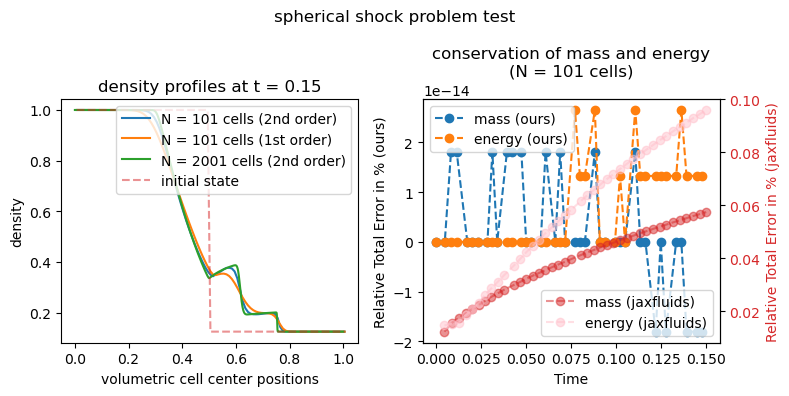

In [16]:
# plot checkpoints_shock.total_mass_proxy and checkpoints_shock.total_energy_proxy over time
relative_mass_error = (checkpoints_shock100.total_mass_proxy - checkpoints_shock100.total_mass_proxy[0]) / checkpoints_shock100.total_mass_proxy[0] * 100
relative_energy_error = (checkpoints_shock100.total_energy_proxy - checkpoints_shock100.total_energy_proxy[0]) / checkpoints_shock100.total_energy_proxy[0] * 100

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[1]
ax.plot(checkpoints_shock100.times, relative_mass_error, "o--", label="mass (ours)")
ax.set_xlabel("Time")
ax.legend(loc = "upper left")

ax.set_ylabel("Relative Total Error in % (ours)")

ax.plot(checkpoints_shock100.times, relative_energy_error, "o--", label="energy (ours)")

ax.legend(loc = "upper left")
ax.set_title("conservation of mass and energy\n(N = 101 cells)")

ax2 = ax.twinx()
# twin x for energy
color = 'tab:red'
# load sod_error.npy (the jaxfluids errors)
sod_error = jnp.load("sod_errors.npy")
times_jaxfluids, mass_errors_jaxfluids, energy_errors_jaxfluids = sod_error
ax2.plot(times_jaxfluids, mass_errors_jaxfluids, "o--", label="mass (jaxfluids)", color=color, alpha=0.5)
ax2.plot(times_jaxfluids, energy_errors_jaxfluids, "o--", label="energy (jaxfluids)", color="pink", alpha=0.5)

ax2.set_ylabel("Relative Total Error in % (jaxfluids)", color=color)

ax2.tick_params(axis='y', labelcolor=color)


ax2.legend(loc = "lower right")

# plot the final density at 101 cells first
# and second order and 2004 cells second order
ax = axs[0]
ax.plot(helper_data_shock100.volumetric_centers, checkpoints_shock100.states[-1,0,:], label="N = 101 cells (2nd order)")
ax.plot(helper_data_shock100_first_order.volumetric_centers, checkpoints_shock100_first_order.states[-1,0,:], label="N = 101 cells (1st order)")
ax.plot(helper_data_shock.volumetric_centers, checkpoints_shock2000.states[-1,0,:], label="N = 2001 cells (2nd order)")
# axis title: density profiles at t = 0.15
ax.set_title("density profiles at t = 0.15")

# also plot the initial state in -- for reference
ax.plot(helper_data_shock100.volumetric_centers, initial_state_shock100[0], "--", label="initial state", alpha=0.5)

ax.set_xlabel("volumetric cell center positions")
ax.set_ylabel("density")

ax.legend(loc = "upper right")

# set figure title
fig.suptitle("spherical shock problem test")

plt.tight_layout()

# print(helper_data_shock.volumetric_centers / helper_data_shock.geometric_centers)

In [7]:
# resolutions_to_test = [641, 1281, 2561, 5121, 10241]

# L1_errors = jnp.zeros(len(resolutions_to_test))

# for idx, num_cells in enumerate(resolutions_to_test):

#     print(f"Testing resolution {num_cells}...")

#     initial_state_test, config_test, params_test, helper_data_test = init_acoustics_problem(num_cells, config, params)
#     final_state_test = time_integration(initial_state_test, config_test, params_test, helper_data_test)
    
#     if alpha == 0:
#         r_test = helper_data_test.geometric_centers
#     else:
#         r_test = helper_data_test.volumetric_centers

#     # Find the indices of the closest points in the high-resolution grid (r_best)
#     indices = jnp.searchsorted(r_best, r_test)

#     # Handle edge cases where searchsorted can give an index out of bounds
#     indices = jnp.clip(indices, 0, len(r_best) - 1)

#     # Compute the L1 error comparing low-res values to closest high-res values
#     L1_error = jnp.sqrt((jnp.mean(jnp.abs(final_state_test[0] - final_state_best[0, indices]))) ** 2 + (jnp.mean(jnp.abs(final_state_test[0] - final_state_best[0, indices]))) ** 2 + (jnp.mean(jnp.abs(final_state_test[0] - final_state_best[0, indices]))) ** 2)

#     L1_errors = L1_errors.at[idx].set(L1_error)

# print(L1_errors)

In [8]:
# resolutions_to_test = jnp.array(resolutions_to_test, dtype=jnp.float64)

# plt.loglog(resolutions_to_test, L1_errors, marker='o')

# # fit a line to the log-log data, to estimate the convergence rate
# m, b = np.polyfit(np.log(resolutions_to_test), np.log(L1_errors), 1)
# plt.loglog(resolutions_to_test, np.exp(m * np.log(resolutions_to_test) + b), linestyle='--', label=f"Convergence rate: {m:.2f}")

# plt.xlabel("Number of cells")
# plt.ylabel("L1 error")
# # plt.title("Convergence of Sod shock tube problem")
# plt.legend()

## Visualization

Text(0.5, 1.0, 'Pressure')

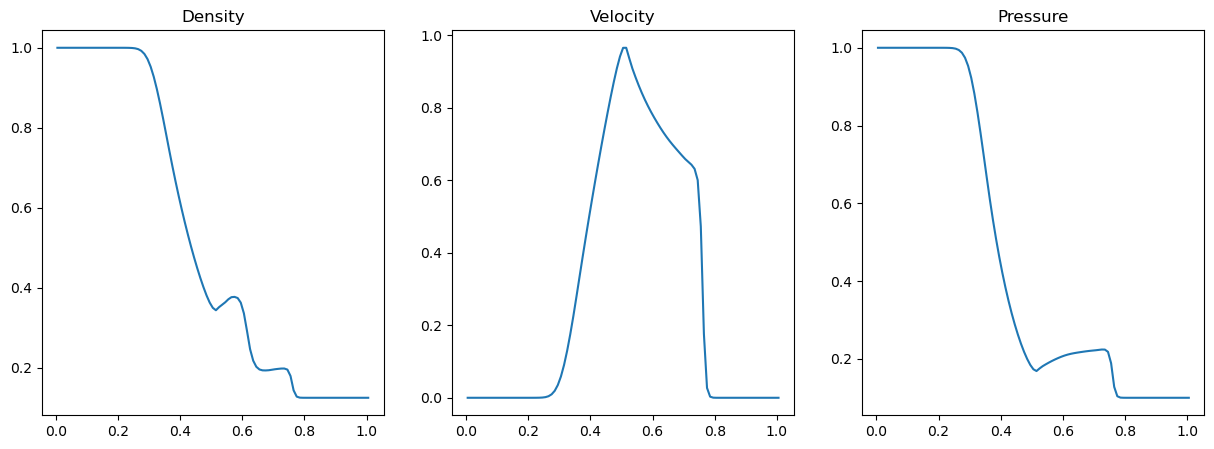

In [9]:
# # initial_state, config, params, helper_data = init_acoustics_problem(100, config, params)

# # final_state = time_integration(initial_state, config, params, helper_data)

rho, u, p = checkpoints_shock100.states[-1]
r = helper_data_shock100.geometric_centers

## plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(r, rho)
axs[0].set_title("Density")

axs[1].plot(r, u)
axs[1].set_title("Velocity")

axs[2].plot(r, p)
axs[2].set_title("Pressure")